### Imports

In [61]:
import os
import json
import numpy as np
from PIL import Image
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import torchvision.transforms as transforms
import torch
from torch.utils.data import TensorDataset, DataLoader, random_split
import torch.nn as nn

### First determining average size of all the crops, so I can keep a fixed size input to the CNN

In [62]:
def compute_image_dimensions(img_dir="./data/imgs"):
    widths = []
    heights = []
    
    # Iterate over files in the directory
    for filename in os.listdir(img_dir):
        if filename.lower().endswith(".jpg"):
            img_path = os.path.join(img_dir, filename)
            try:
                with Image.open(img_path) as img:
                    w, h = img.size
                    widths.append(w)
                    heights.append(h)
            except Exception as e:
                print(f"Error loading image {img_path}: {e}")
    
    if not widths or not heights:
        print("No images processed successfully.")
        return
    
    avg_width = np.mean(widths)
    avg_height = np.mean(heights)
    min_width = np.min(widths)
    max_width = np.max(widths)
    min_height = np.min(heights)
    max_height = np.max(heights)
    
    print("Average width:", avg_width)
    print("Average height:", avg_height)
    print("Min width:", min_width)
    print("Max width:", max_width)
    print("Min height:", min_height)
    print("Max height:", max_height)

In [63]:
compute_image_dimensions("./data/imgs")

Average width: 32.559698439600254
Average height: 43.53743206124715
Min width: 7
Max width: 81
Min height: 10
Max height: 98


### Functions for preprocessing and loading

In [64]:
# Preprocessing
transform = transforms.Compose([
    transforms.Resize(64),      # Resize the smaller edge to 64 while keeping aspect ratio
    transforms.CenterCrop(64),  # Ensures final size is 64x64
    transforms.ToTensor()       # Convert to PyTorch tensor (C, H, W)
])

In [ ]:
# For each cropped jersey number image (named as <num>_<frame>.jpg), it extracts the <num> part from the name   
# and looks up its ground truth in the JSON file, loads the image, performs transformations, and appends it to a list.

def load_data(img_dir="./data/imgs", gt_file="./data/test_gt.json", multi_label = False):
    with open(gt_file, "r") as f:
        gt_data = json.load(f)
    
    images = []
    labels = []
    
    for filename in os.listdir(img_dir):
        if filename.endswith(".jpg"):
            key = filename.split("_")[0]  # Extract player ID from filename
            label = gt_data[key]

            img_path = os.path.join(img_dir, filename)
            try:
                img = Image.open(img_path).convert("RGB")  
                img_tensor = transform(img)  
            except Exception as e:
                print(f"Error loading image {img_path}: {e}")
                continue 
            
            images.append(img_tensor)

            if multi_label:     # i.e. we use separate labels for each digit (so the model will have to output them separately)
                if label == -1:
                    labels.append([10, 10])     # if we use separate labels and the actual label is -1, then both digits should be illegible, denote with 10
                    continue

                tens = label // 10
                ones = label % 10
                labels.append([tens, ones])
            
            else:
                if label == -1:
                    labels.append(0)      # we use 0 to denote the illegible class since nn.CrossEntropyLoss() requires labels starting at 0
                    continue

                labels.append(label)
    
    return torch.stack(images), torch.tensor(labels, dtype=torch.long)  # return Tensors

def plot_label_histogram(labels, multi_label=False):
    """TODO: if multi-label then maybe show two plots, one for each digit?"""

    if multi_label:
        # Convert the tens and ones digits back to the original labels
        labels_as_int = [tens * 10 + ones if tens != 10 and ones != 10 else 0 for tens, ones in labels]
    else:
        labels_as_int = [int(label) for label in labels]
    
    # Set up the bins so that each integer gets its own bar
    bins = np.arange(0, 100 + 2)  # +2 so that the upper value is included
    plt.figure(figsize=(10, 6))
    plt.hist(labels_as_int, bins=bins, edgecolor='black', align='left')
    plt.xlabel("Ground Truth Number")
    plt.ylabel("Frequency")
    plt.title(f"Histogram of Ground Truth Numbers (-1-99)")
    plt.xticks(np.arange(0, 100 + 1, step=2))  
    plt.show()

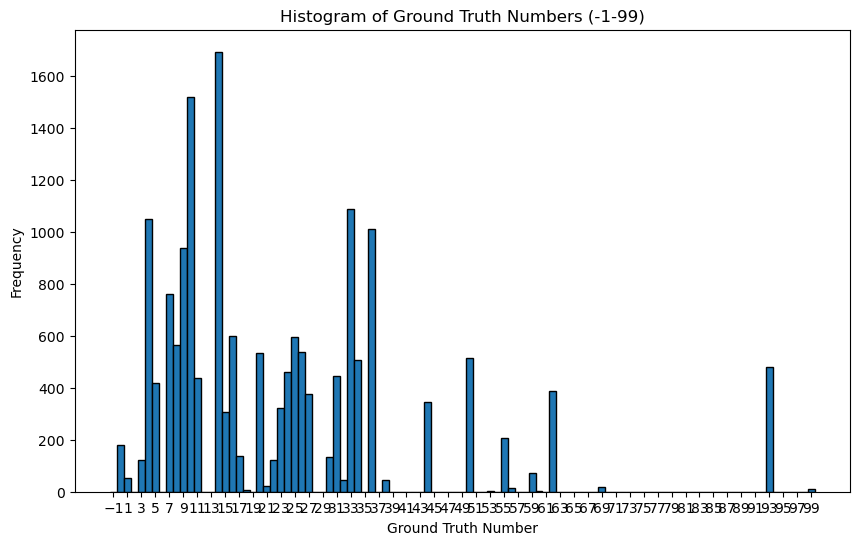

In [66]:
images, labels = load_data("./data/imgs", "./data/test_gt.json")
plot_label_histogram(labels)

It looks like the numbers between 1-35 are common, with 14 having the most inputs.  

In [91]:
dataset = TensorDataset(images, labels)

# 95-5 train-test split
train_size = round(0.95 * len(dataset))
test_size = round(0.05 * len(dataset))
train_dataset, test_dataset = random_split(dataset, [train_size, test_size])

# For initial model testing, try to overfit to a small subset of the training data to see if the model has sufficient complexity
small_train_size = int(0.15 * len(train_dataset))
small_train_dataset = torch.utils.data.Subset(train_dataset, range(small_train_size)) 

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True, num_workers=2)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False, num_workers=2)
small_train_loader = DataLoader(small_train_dataset, batch_size=32, shuffle=True, num_workers=2)

print(f"Total dataset size: {len(dataset)}")
print(f"Train dataset size: {len(train_dataset)}")
print(f"Test dataset size: {len(test_dataset)}")
print(f"Small test dataset size: {len(small_train_dataset)}")

Total dataset size: 17111
Train dataset size: 16255
Test dataset size: 856
Small test dataset size: 2438


### Visualizing dataset

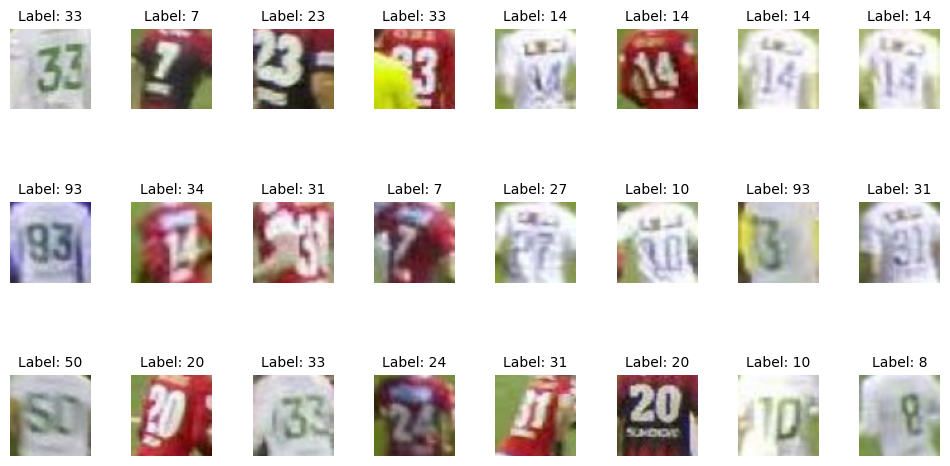

In [92]:
image_batch, label_batch = next(iter(train_loader))  # Get the next batch from the train loader

num_cols = 8
num_rows = 3

fig, axes = plt.subplots(num_rows, num_cols, figsize=(12, 6))

# Flatten the axes to make it easier to index them
axes = axes.flatten()

for i in range(num_rows * num_cols):
    ax = axes[i]
    image = image_batch[i].permute(1, 2, 0).numpy()  # Convert from CxHxW to HxWxC
    # image = image * 1 + 0  
    ax.imshow(image, cmap='gray')
    ax.set_title(f'Label: {label_batch[i].item()}', fontsize=10)
    ax.axis('off')  # Turn off the axes for each subplot

plt.subplots_adjust(wspace=0.5, hspace=0.5)
plt.show()

### Training the model

In [93]:
class JerseyNumberClassifier(nn.Module):
    def __init__(self):
        super(JerseyNumberClassifier, self).__init__()
        
        # 64x64 input
        self.block1 = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv2d(64, 64, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
        )
        
        # 32x32 inputs
        self.block2 = nn.Sequential(
            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv2d(128, 128, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
        )
        
        # 16x16 inputs
        self.block3 = nn.Sequential(
            nn.Conv2d(128, 256, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv2d(256, 256, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
        )
        
        # 8x8 inputs 
        self.block4 = nn.Sequential(
            nn.Conv2d(256, 512, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv2d(512, 512, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
        )
        
        # 4x4 inputs
        self.block5 = nn.Sequential(
            nn.Conv2d(512, 512, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv2d(512, 512, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
        )

        # 2x2 inputs
        self.block6 = nn.Sequential(
            nn.Conv2d(512, 1024, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv2d(1024, 1024, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
        )
        
        # 1x1 inputs
        self.fc = nn.Sequential(
            nn.Linear(1024 * 1 * 1, 8192),   # output of last conv block is 1024 * 1 * 1
            nn.ReLU(),
            nn.Linear(8192, 4096),
            nn.ReLU(),
            nn.Linear(4096, 1024),
            nn.ReLU(),
            nn.Linear(1024, 100)
        )
    
    def forward(self, x):
        x = self.block1(x)
        x = self.block2(x)
        x = self.block3(x)
        x = self.block4(x)
        x = self.block5(x)
        x = self.block6(x)
        x = torch.flatten(x, start_dim=1)  
        x = self.fc(x)
        return x


In [94]:
DEVICE = torch.device("cuda")

First, we will try to overfit to a small subset of the training data to ensure that the model is sufficiently complex.

In [99]:
test_net = JerseyNumberClassifier()
test_net = test_net.to(DEVICE)

In [100]:
# %pip install torchsummary

from torchsummary import summary
summary(test_net, (3,64,64))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 64, 64]           1,792
              ReLU-2           [-1, 64, 64, 64]               0
            Conv2d-3           [-1, 64, 64, 64]          36,928
              ReLU-4           [-1, 64, 64, 64]               0
         MaxPool2d-5           [-1, 64, 32, 32]               0
            Conv2d-6          [-1, 128, 32, 32]          73,856
              ReLU-7          [-1, 128, 32, 32]               0
            Conv2d-8          [-1, 128, 32, 32]         147,584
              ReLU-9          [-1, 128, 32, 32]               0
        MaxPool2d-10          [-1, 128, 16, 16]               0
           Conv2d-11          [-1, 256, 16, 16]         295,168
             ReLU-12          [-1, 256, 16, 16]               0
           Conv2d-13          [-1, 256, 16, 16]         590,080
             ReLU-14          [-1, 256,

In [101]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(test_net.parameters(), lr=0.001)

In [102]:
total_train_losses = []
total_train_acc = []
TEST_EPOCHS = 20

for epoch in range(TEST_EPOCHS):

    total_loss_in_epoch = 0
    correct_preds = 0
    total_preds = 0

    # Training 
    for inputs, ground_truths in small_train_loader:

        inputs = inputs.to(DEVICE)
        ground_truths = ground_truths.to(DEVICE)
        
        optimizer.zero_grad()
        outputs = test_net(inputs)    
        loss = criterion(outputs, ground_truths)     
        loss.backward()
        optimizer.step()

        total_loss_in_epoch += loss.item()       # accumulate loss for this batch
        correct_preds += (torch.argmax(outputs, dim=1) == ground_truths).sum().item()
        total_preds += outputs.size(0)

    # average out the loss and accuracy across the batch
    avg_train_loss = round(total_loss_in_epoch / inputs.size(0), 4)
    train_accuracy = round((correct_preds / total_preds) * 100, 4)

    total_train_losses.append(avg_train_loss)
    total_train_acc.append(train_accuracy)

    print(f"Epoch {epoch+1}/{TEST_EPOCHS}")
    print(f"Train Loss: {avg_train_loss} | Train Accuracy: {train_accuracy}% \nNumber of jersey numbers correctly predicted: {correct_preds}")
    print("=" * 20)


Epoch 1/20
Train Loss: 48.8662 | Train Accuracy: 8.3265% 
Number of jersey numbers correctly predicted: 203
Epoch 2/20
Train Loss: 42.3125 | Train Accuracy: 9.1058% 
Number of jersey numbers correctly predicted: 222
Epoch 3/20
Train Loss: 42.2881 | Train Accuracy: 9.6801% 
Number of jersey numbers correctly predicted: 236
Epoch 4/20
Train Loss: 42.194 | Train Accuracy: 9.3109% 
Number of jersey numbers correctly predicted: 227
Epoch 5/20
Train Loss: 42.0918 | Train Accuracy: 9.516% 
Number of jersey numbers correctly predicted: 232
Epoch 6/20
Train Loss: 42.0561 | Train Accuracy: 9.1879% 
Number of jersey numbers correctly predicted: 224
Epoch 7/20
Train Loss: 42.0719 | Train Accuracy: 10.2133% 
Number of jersey numbers correctly predicted: 249
Epoch 8/20
Train Loss: 42.0367 | Train Accuracy: 9.3519% 
Number of jersey numbers correctly predicted: 228
Epoch 9/20
Train Loss: 42.086 | Train Accuracy: 10.3363% 
Number of jersey numbers correctly predicted: 252
Epoch 10/20
Train Loss: 42.05

Looking at the examples it got wrong:

In [103]:
wrong_images = []
wrong_labels = []
wrong_predictions = []

with torch.no_grad():
    for inputs, labels in test_loader:
        inputs = inputs.to(DEVICE)
        labels = labels.to(DEVICE)

        outputs = test_net(inputs)
        _, preds = torch.max(outputs, 1)

        # Check each image in the batch for misclassification
        for i in range(len(labels)):
            if preds[i] != labels[i]:
                wrong_images.append(inputs[i].cpu())
                wrong_labels.append(labels[i].cpu().item())
                wrong_predictions.append(preds[i].cpu().item())


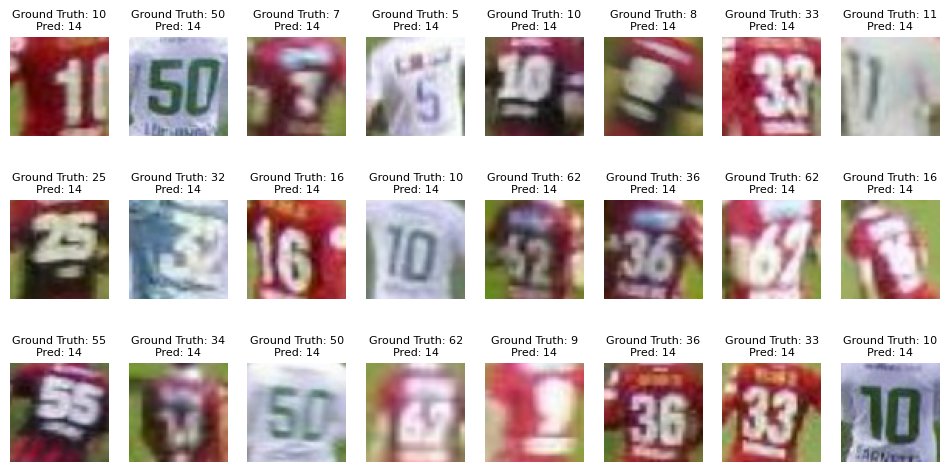

In [107]:
num_cols = 8
num_rows = 3
fig, axes = plt.subplots(num_rows, num_cols, figsize=(12, 6))

# Flatten the axes to make it easier to index them
axes = axes.flatten()

for i in range(num_rows * num_cols):
    if i < len(images):  # so that we don't try to access more images than available in the batch
        ax = axes[i]
        image = wrong_images[i]
        # Convert from CxHxW to HxWxC for plotting
        image_np = image.permute(1, 2, 0).numpy()

        ax.imshow(image_np, cmap='gray')
        ax.set_title(f"Ground Truth: {wrong_labels[i]}\nPred: {wrong_predictions[i]}", fontsize=8)
        ax.axis('off')
    else:
        ax = axes[i]
        ax.axis('off')

plt.subplots_adjust()
plt.show()


In [108]:
count_label_14 = 0
total_images = 0

for _, labels in small_train_loader:
    count_label_14 += (labels == 14).sum().item()
    total_images += labels.size(0)

percentage_label_14 = (count_label_14 / total_images) * 100
print(f"Percentage of images with label 14: {percentage_label_14:.2f}%")

Percentage of images with label 14: 9.76%


This performance is terrible. It has just learned to predict the number 14, and since that seems to be the most common in the small subset, it is only predicting 14. We should try a multi-label output (i.e. model should now output 2 labels, one for each digit, with values between 0-10 where 0-9 is for digits and 10 is for illegible)

In [114]:
import torch
import torch.nn as nn

class JerseyNumberMultiLabelClassifier(nn.Module):
    def __init__(self):
        super(JerseyNumberMultiLabelClassifier, self).__init__()
        
        # 64x64 input
        self.block1 = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv2d(64, 64, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
        )
        
        # 32x32 inputs
        self.block2 = nn.Sequential(
            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv2d(128, 128, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
        )
        
        # 16x16 inputs
        self.block3 = nn.Sequential(
            nn.Conv2d(128, 256, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv2d(256, 256, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
        )
        
        # 8x8 inputs 
        self.block4 = nn.Sequential(
            nn.Conv2d(256, 512, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv2d(512, 512, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
        )
        
        # 4x4 inputs
        self.block5 = nn.Sequential(
            nn.Conv2d(512, 512, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv2d(512, 512, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
        )

        # 2x2 inputs
        self.block6 = nn.Sequential(
            nn.Conv2d(512, 1024, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv2d(1024, 1024, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
        )
        
        # Shared fully-connected layers
        self.shared_fc = nn.Sequential(
            nn.Linear(1024 * 1 * 1, 8192),   # flatten 1024*1*1 features
            nn.ReLU(),
            nn.Linear(8192, 4096),
            nn.ReLU(),
            nn.Linear(4096, 1024),
            nn.ReLU(),
        )
        
        # Two separate classifier heads, each for 11 classes (0-9 digits and 10 for illegible)
        self.fc_digit1 = nn.Linear(1024, 11)
        self.fc_digit2 = nn.Linear(1024, 11)
    
    def forward(self, x):
        x = self.block1(x)
        x = self.block2(x)
        x = self.block3(x)
        x = self.block4(x)
        x = self.block5(x)
        x = self.block6(x)
        x = torch.flatten(x, start_dim=1)  
        x = self.shared_fc(x)
        out_digit1 = self.fc_digit1(x)
        out_digit2 = self.fc_digit2(x)
        return out_digit1, out_digit2


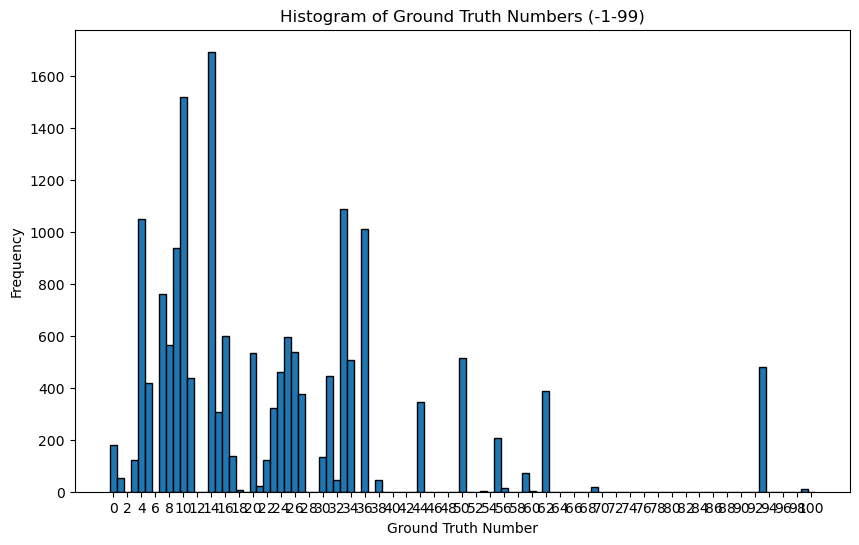

In [116]:
# Reinitialize images and labels
images, labels = load_data("./data/imgs", "./data/test_gt.json", multi_label=True)
plot_label_histogram(labels, multi_label=True)

Data looks the same, so create new dataloaders

In [117]:
dataset = TensorDataset(images, labels)

# 95-5 train-test split
train_size = round(0.95 * len(dataset))
test_size = round(0.05 * len(dataset))
train_dataset, test_dataset = random_split(dataset, [train_size, test_size])

# For initial model testing, try to overfit to a small subset of the training data to see if the model has sufficient complexity
small_train_size = int(0.15 * len(train_dataset))
small_train_dataset = torch.utils.data.Subset(train_dataset, range(small_train_size)) 

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True, num_workers=2)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False, num_workers=2)
small_train_loader = DataLoader(small_train_dataset, batch_size=32, shuffle=True, num_workers=2)

print(f"Total dataset size: {len(dataset)}")
print(f"Train dataset size: {len(train_dataset)}")
print(f"Test dataset size: {len(test_dataset)}")
print(f"Small test dataset size: {len(small_train_dataset)}")

Total dataset size: 17111
Train dataset size: 16255
Test dataset size: 856
Small test dataset size: 2438


In [124]:
digitwise_net = JerseyNumberMultiLabelClassifier()
digitwise_net = digitwise_net.to(DEVICE)
summary(digitwise_net, (3,64,64))

digitwise_optimizer = torch.optim.Adam(digitwise_net.parameters(), lr = 0.001)

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 64, 64]           1,792
              ReLU-2           [-1, 64, 64, 64]               0
            Conv2d-3           [-1, 64, 64, 64]          36,928
              ReLU-4           [-1, 64, 64, 64]               0
         MaxPool2d-5           [-1, 64, 32, 32]               0
            Conv2d-6          [-1, 128, 32, 32]          73,856
              ReLU-7          [-1, 128, 32, 32]               0
            Conv2d-8          [-1, 128, 32, 32]         147,584
              ReLU-9          [-1, 128, 32, 32]               0
        MaxPool2d-10          [-1, 128, 16, 16]               0
           Conv2d-11          [-1, 256, 16, 16]         295,168
             ReLU-12          [-1, 256, 16, 16]               0
           Conv2d-13          [-1, 256, 16, 16]         590,080
             ReLU-14          [-1, 256,

In [129]:
total_train_losses = []
total_train_acc = []
TEST_EPOCHS = 10

for epoch in range(TEST_EPOCHS):

    total_loss_in_epoch = 0
    correct_preds = 0
    total_preds = 0

    # Training 
    for inputs, ground_truths in small_train_loader:

        inputs = inputs.to(DEVICE)
        ground_truths = ground_truths.to(DEVICE)
        
        optimizer.zero_grad()
        out_digit1, out_digit2 = digitwise_net(inputs)
        
        # Compute the loss for each digit classification separately.
        loss1 = criterion(out_digit1, ground_truths[:, 0])
        loss2 = criterion(out_digit2, ground_truths[:, 1])
        loss = (loss1 + loss2) / 2  # average the losses

        loss.backward()
        optimizer.step()

        total_loss_in_epoch += loss.item()  # accumulate loss for this batch

        # Check for accuracy for each digit separately
        correct_digit1 = torch.argmax(out_digit1, dim=1) == ground_truths[:, 0]
        correct_digit2 = torch.argmax(out_digit2, dim=1) == ground_truths[:, 1]
        correct_preds += (correct_digit1 & correct_digit2).sum().item()     # AND (bitwise operation) the losses 
        total_preds += out_digit1.size(0)

    # average out the loss and accuracy across the batch
    avg_train_loss = round(total_loss_in_epoch / inputs.size(0), 4)
    train_accuracy = round((correct_preds / total_preds) * 100, 4)

    total_train_losses.append(avg_train_loss)
    total_train_acc.append(train_accuracy)

    print(f"Epoch {epoch+1}/{TEST_EPOCHS}")
    print(f"Train Loss: {avg_train_loss} | Train Accuracy: {train_accuracy}% \nNumber of jersey numbers correctly predicted: {correct_preds}")
    print("=" * 20)


Epoch 1/10
Train Loss: 30.6886 | Train Accuracy: 3.6916% 
Number of jersey numbers correctly predicted: 90
Epoch 2/10
Train Loss: 30.6872 | Train Accuracy: 3.6916% 
Number of jersey numbers correctly predicted: 90
Epoch 3/10
Train Loss: 30.6874 | Train Accuracy: 3.6916% 
Number of jersey numbers correctly predicted: 90
Epoch 4/10
Train Loss: 30.6875 | Train Accuracy: 3.6916% 
Number of jersey numbers correctly predicted: 90
Epoch 5/10
Train Loss: 30.6881 | Train Accuracy: 3.6916% 
Number of jersey numbers correctly predicted: 90
Epoch 6/10
Train Loss: 30.6879 | Train Accuracy: 3.6916% 
Number of jersey numbers correctly predicted: 90
Epoch 7/10
Train Loss: 30.6878 | Train Accuracy: 3.6916% 
Number of jersey numbers correctly predicted: 90
Epoch 8/10
Train Loss: 30.6876 | Train Accuracy: 3.6916% 
Number of jersey numbers correctly predicted: 90
Epoch 9/10
Train Loss: 30.6868 | Train Accuracy: 3.6916% 
Number of jersey numbers correctly predicted: 90
Epoch 10/10
Train Loss: 30.6867 | Tra